In [65]:
import pandas as pd
import torch
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

from AttentiveFP import Fingerprint  # assumed to be your attentive FP model
from AttentiveFP import get_smiles_dicts, get_smiles_array, num_atom_features, \
    num_bond_features  # assumed to be your actual featurizer

In [66]:
# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = 'Irritation_Corrosion_Eye_Irritation'

# --- Dataset ---
class MoleculeDataset(Dataset):
    def __init__(self, smiles_list, targets, feature_dicts):
        self.smiles_list = smiles_list
        self.targets = targets
        self.feature_dicts = feature_dicts
        self.x_atom, self.x_bond, self.x_atom_index, self.x_bond_index, self.x_mask, _ = get_smiles_array(smiles_list, feature_dicts)

    def __len__(self):
        return len(self.feature_dicts)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.x_atom[idx], dtype=torch.float32),
            torch.tensor(self.x_bond[idx], dtype=torch.float32),
            torch.tensor(self.x_atom_index[idx], dtype=torch.long),
            torch.tensor(self.x_bond_index[idx], dtype=torch.long),
            torch.tensor(self.x_mask[idx], dtype=torch.float32),
            torch.tensor(self.targets[idx], dtype=torch.float32)
        )

In [67]:
import logging
from rdkit import Chem
from pathlib import Path

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# --- Load data ---
# --- Load and validate data ---
df = pd.read_csv(f"../data/{model_name}.csv")
data_path = Path(f"../data/{model_name}.csv")
smiles_list = df["smiles"].tolist()
if not data_path.exists():
    raise FileNotFoundError(f"Data file not found: {data_path}")

df = pd.read_csv(data_path)
targets = df["active"].tolist()
feature_dicts = get_smiles_dicts(smiles_list)
logger.info(f"Loaded dataset with {len(df)} samples")

# Validate SMILES and targets
valid_idx = []
valid_smiles = []
valid_targets = []

for idx, (smiles, target) in enumerate(zip(df["smiles"], df["active"])):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None and isinstance(target, (int, float)) and target in [0, 1]:
        valid_idx.append(idx)
        valid_smiles.append(smiles)
        valid_targets.append(target)
    else:
        logger.warning(f"Invalid entry at index {idx}: SMILES={smiles}, target={target}")

logger.info(f"Valid samples: {len(valid_smiles)} out of {len(df)}")

# Check class distribution
from collections import Counter
initial_distribution = Counter(valid_targets)
logger.info(f"Initial class distribution: {initial_distribution}")

# First split: 60% train, 20% val, 20% test
# First split: 60% train, 20% val, 20% test with stratification
from sklearn.model_selection import train_test_split

train_smiles, temp_smiles, train_targets, temp_targets = train_test_split(
    valid_smiles, valid_targets, test_size=0.4, random_state=42, stratify=valid_targets
)

val_smiles, test_smiles, val_targets, test_targets = train_test_split(
    temp_smiles, temp_targets, test_size=0.5, random_state=42, stratify=temp_targets
)

logger.info(f"Train samples: {len(train_smiles)}")
logger.info(f"Val samples: {len(val_smiles)}")
logger.info(f"Test samples: {len(test_smiles)}")

# Apply oversampling only to training data
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample([[s] for s in train_smiles], train_targets)
train_smiles_resampled = [x[0] for x in X_res]

print("Class distribution in original training set:", Counter(train_targets))
logger.info("Class distribution:")
logger.info(f"Original training set: {Counter(train_targets)}")
print("Class distribution after resampling:", Counter(y_res))
logger.info(f"After resampling: {Counter(y_res)}")
logger.info(f"Validation set: {Counter(val_targets)}")
logger.info(f"Test set: {Counter(test_targets)}")

# Flatten X_res to get new smiles
# Calculate class weights based on original training data
from sklearn.utils.class_weight import compute_class_weight
smiles_list_resampled = [x[0] for x in X_res]

class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=train_targets)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}
print("Class weights:", class_weights_dict)
logger.info(f"Class weights: {class_weights_dict}")

print(Counter(y_res))  # See new class balance
# Convert to tensor for PyTorch
pos_weight = torch.tensor([class_weights_dict[1] / class_weights_dict[0]], device=device)

# Let's check these values
print("n_samples:", n_samples)
print("n_positives:", n_positives)
print("pos_weight:", pos_weight)

# And check the actual output of the model
with torch.no_grad():
    batch = next(iter(train_loader))
    atom, bond, atom_deg, bond_deg, mask, target = [t.to(device) for t in batch]
    _, pred, _ = model(atom, bond, atom_deg, bond_deg, mask)
    print("\nSample predictions:")
    print("Raw model output:", pred[:5].cpu().numpy())
    print("After sigmoid:", torch.sigmoid(pred[:5]).cpu().numpy())
    print("Actual targets:", target[:5].cpu().numpy())

# Rebuild features and dataset
# Get feature dictionaries for all sets
try:
    feature_dicts_resampled = get_smiles_dicts(smiles_list_resampled)
    dataset = MoleculeDataset(smiles_list_resampled, y_res, feature_dicts_resampled)
    loader = DataLoader(dataset, batch_size=32, shuffle=True)
    feature_dicts_val = get_smiles_dicts(val_smiles)
    feature_dicts_test = get_smiles_dicts(test_smiles)
except Exception as e:
    logger.error(f"Error generating feature dictionaries: {e}")
    raise

# Create datasets
train_dataset = MoleculeDataset(train_smiles_resampled, y_res, feature_dicts_resampled)
val_dataset = MoleculeDataset(val_smiles, val_targets, feature_dicts_val)
test_dataset = MoleculeDataset(test_smiles, test_targets, feature_dicts_test)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



FS(F)(F)(F)(F)c1ccccc1


INFO:__main__:Loaded dataset with 5125 samples
INFO:__main__:Valid samples: 5125 out of 5125
INFO:__main__:Initial class distribution: Counter({1: 3832, 0: 1293})
INFO:__main__:Train samples: 3075
INFO:__main__:Val samples: 1025
INFO:__main__:Test samples: 1025
INFO:__main__:Class distribution:
INFO:__main__:Original training set: Counter({1: 2299, 0: 776})
INFO:__main__:After resampling: Counter({1: 2299, 0: 2299})
INFO:__main__:Validation set: Counter({1: 767, 0: 258})
INFO:__main__:Test set: Counter({1: 766, 0: 259})
INFO:__main__:Class weights: {0: 1.9813144329896908, 1: 0.6687690300130491}


Class distribution in original training set: Counter({1: 2299, 0: 776})
Class distribution after resampling: Counter({1: 2299, 0: 2299})
Class weights: {0: 1.9813144329896908, 1: 0.6687690300130491}
Counter({1: 2299, 0: 2299})
n_samples: 5125
n_positives: 3832
pos_weight: tensor([0.3375], dtype=torch.float64)

Sample predictions:
Raw model output: [[ 0.0747022 ]
 [-0.01109375]
 [-0.0158276 ]
 [-0.01383139]
 [ 0.00062453]]
After sigmoid: [[0.51866686]
 [0.49722657]
 [0.49604318]
 [0.49654222]
 [0.50015616]]
Actual targets: [1. 1. 1. 1. 1.]
FS(F)(F)(F)(F)c1ccccc1


In [68]:
# --- Model ---
model = Fingerprint(
    radius=5,
    T=3,  # Increased T for better message passing
    input_feature_dim=num_atom_features(),
    input_bond_dim=num_bond_features(),
    fingerprint_dim=150,  # Increased dimension for more complex feature learning
    output_units_num=1,
    p_dropout=0.3  # Increased dropout for better regularization
).to(device)

# Using a lower learning rate and higher weight decay for better generalization
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Calculate class weights based on the original class distribution
# Use weighted loss function
loss_fn = BCEWithLogitsLoss(pos_weight=pos_weight)


In [69]:
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import numpy as np
import os

def init_early_stopping(patience=5):
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    return best_val_loss, patience_counter, best_model_state

# Add before training loop
best_val_loss, patience_counter, best_model_state = init_early_stopping(patience=5)


def evaluate(loader):
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []
    all_probs = []

    with torch.no_grad():
        for atom, bond, atom_deg, bond_deg, mask, target in loader:
            atom, bond, atom_deg, bond_deg, mask, target = [
                t.to(device) for t in (atom, bond, atom_deg, bond_deg, mask, target)
            ]
            _, pred, _ = model(atom, bond, atom_deg, bond_deg, mask)
            pred = pred.view(-1)
            target = target.view(-1).float()

            loss = loss_fn(pred, target)
            total_loss += loss.item()

            prob = torch.sigmoid(pred).cpu().numpy()
            all_probs.extend(prob)
            all_preds.extend((prob > 0.5).astype(int))
            all_targets.extend(target.cpu().numpy())

    acc = accuracy_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds, zero_division=0)
    try:
        auc = roc_auc_score(all_targets, all_probs)
    except:
        auc = 0.0
    return total_loss, acc, f1, auc

# Folder to save model
os.makedirs("../models", exist_ok=True)
best_loss = float("inf")
path = f"../models/model_{model_name}.pt"

for epoch in range(30):
    model.train()
    train_loss = 0

    for batch in train_loader:
        atom, bond, atom_deg, bond_deg, mask, target = [
            t.to(device) for t in batch
        ]
        optimizer.zero_grad()
        _, pred, _ = model(atom, bond, atom_deg, bond_deg, mask)
        loss = loss_fn(pred.squeeze(), target)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Add gradient clipping
        optimizer.step()
        train_loss += loss.item()

    val_loss, val_acc, val_f1, val_auc = evaluate(val_loader)
    scheduler.step(val_loss)  # Update learning rate based on validation loss

    print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} "
          f"- Val Acc: {val_acc:.3f} - Val F1: {val_f1:.3f} - Val AUC: {val_auc:.3f} "
          f"- LR: {optimizer.param_groups[0]['lr']:.6f}")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        patience_counter = 0
        torch.save(model.state_dict(), path)
        print(f"✅ Saved best model (val loss: {best_val_loss:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= 5:  # Early stopping patience
            print("Early stopping triggered!")
            break



Epoch 1 - Train Loss: 0.3152 - Val Loss: 0.3642 - Val Acc: 0.333 - Val F1: 0.000 - Val AUC: 1.000 - LR: 0.001000
✅ Saved best model (val loss: 0.3642)
Epoch 2 - Train Loss: 0.2909 - Val Loss: 0.3350 - Val Acc: 0.333 - Val F1: 0.000 - Val AUC: 1.000 - LR: 0.001000
✅ Saved best model (val loss: 0.3350)
Epoch 3 - Train Loss: 0.2721 - Val Loss: 0.3047 - Val Acc: 0.333 - Val F1: 0.000 - Val AUC: 1.000 - LR: 0.001000
✅ Saved best model (val loss: 0.3047)
Epoch 4 - Train Loss: 0.2512 - Val Loss: 0.2779 - Val Acc: 0.500 - Val F1: 0.400 - Val AUC: 1.000 - LR: 0.001000
✅ Saved best model (val loss: 0.2779)
Epoch 5 - Train Loss: 0.2329 - Val Loss: 0.2652 - Val Acc: 0.500 - Val F1: 0.400 - Val AUC: 1.000 - LR: 0.001000
✅ Saved best model (val loss: 0.2652)
Epoch 6 - Train Loss: 0.2130 - Val Loss: 0.2659 - Val Acc: 0.833 - Val F1: 0.857 - Val AUC: 1.000 - LR: 0.001000
Epoch 7 - Train Loss: 0.1914 - Val Loss: 0.2848 - Val Acc: 1.000 - Val F1: 1.000 - Val AUC: 1.000 - LR: 0.001000
Epoch 8 - Train Los

In [70]:
# Load best model
model.load_state_dict(torch.load(path))
model.to(device)

test_loss, test_acc, test_f1, test_auc = evaluate(test_loader)
print(f"🧪 Test Loss: {test_loss:.4f} - Acc: {test_acc:.3f} - F1: {test_f1:.3f} - AUC: {test_auc:.3f}")

🧪 Test Loss: 0.2276 - Acc: 0.833 - F1: 0.909 - AUC: 0.000


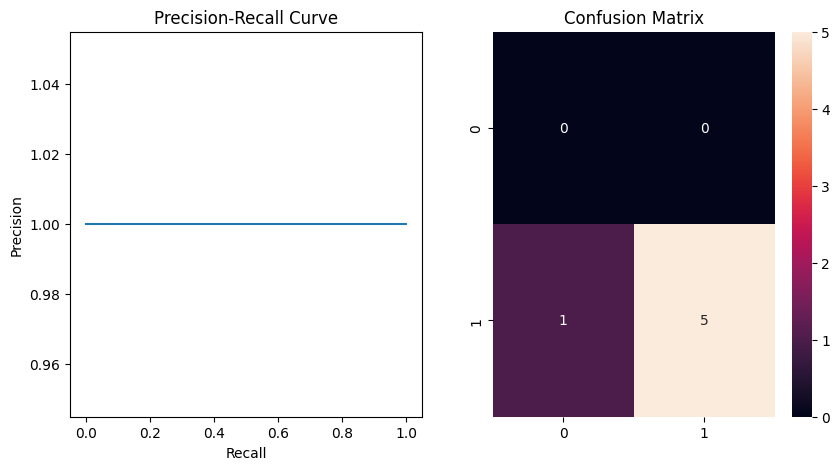

Checking initial data distribution...

Checking data distribution:
Training set distribution: (array([0., 1.], dtype=float32), array([1, 5]))
Validation set distribution: (array([0., 1.], dtype=float32), array([2, 4]))
Test set distribution: (array([1.], dtype=float32), array([6]))

Running detailed evaluation on validation set...

Batch 1 Statistics:
Predictions distribution: (array([0, 1]), array([5, 1]))
Targets distribution: (array([0., 1.], dtype=float32), array([2, 4]))
Raw probabilities range: 0.144 to 0.522

Overall Statistics:
Total predictions shape: (6,)
Predictions distribution: (array([0, 1]), array([5, 1]))
Targets distribution: (array([0., 1.], dtype=float32), array([2, 4]))

Detailed Metrics:
Precision: 1.000
Recall: 0.250
Confusion Matrix:
[[2 0]
 [3 1]]
Calculated positive class weight: 1.000

Epoch 1/30

Gradients for atom_fc.weight:
Mean: 0.000151
Std: 0.002320

Gradients for atom_fc.bias:
Mean: 0.001255
Std: 0.006512

Gradients for neighbor_fc.weight:
Mean: -0.0000

/tmp/ipykernel_778194/528031549.py:173: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  print(f"Std: {param.grad.std().item():.6f}")


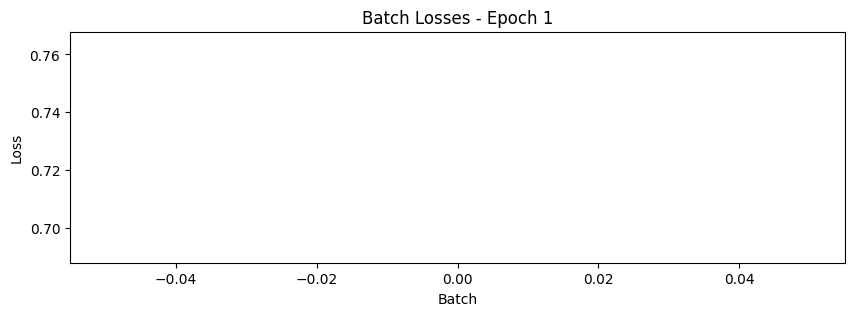

✓ Saved best model

Epoch 2/30

Gradients for atom_fc.weight:
Mean: 0.000037
Std: 0.002135

Gradients for atom_fc.bias:
Mean: 0.000293
Std: 0.005796

Gradients for neighbor_fc.weight:
Mean: -0.000063
Std: 0.000738

Gradients for neighbor_fc.bias:
Mean: -0.000404
Std: 0.001902

Gradients for GRUCell.0.weight_ih:
Mean: 0.000002
Std: 0.000563

Gradients for GRUCell.0.weight_hh:
Mean: 0.000014
Std: 0.000369

Gradients for GRUCell.0.bias_ih:
Mean: 0.000279
Std: 0.004645

Gradients for GRUCell.0.bias_hh:
Mean: 0.000124
Std: 0.002340

Gradients for GRUCell.1.weight_ih:
Mean: 0.000003
Std: 0.000682

Gradients for GRUCell.1.weight_hh:
Mean: 0.000006
Std: 0.000434

Gradients for GRUCell.1.bias_ih:
Mean: 0.000260
Std: 0.008143

Gradients for GRUCell.1.bias_hh:
Mean: 0.000101
Std: 0.004197

Gradients for GRUCell.2.weight_ih:
Mean: -0.000009
Std: 0.001186

Gradients for GRUCell.2.weight_hh:
Mean: 0.000008
Std: 0.000532

Gradients for GRUCell.2.bias_ih:
Mean: 0.000853
Std: 0.015566

Gradients for GR

/tmp/ipykernel_778194/528031549.py:173: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  print(f"Std: {param.grad.std().item():.6f}")


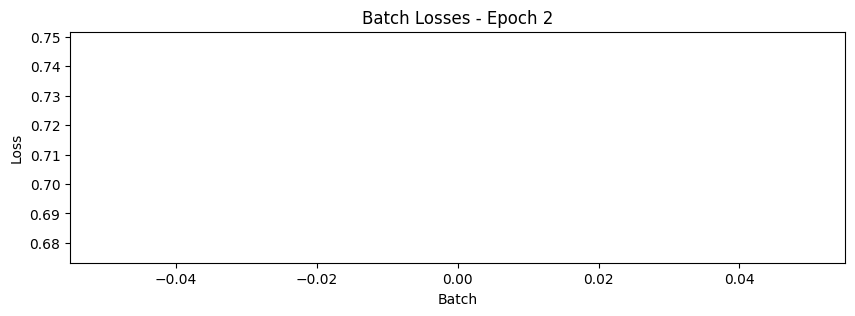

✓ Saved best model

Epoch 3/30

Gradients for atom_fc.weight:
Mean: -0.000026
Std: 0.002012

Gradients for atom_fc.bias:
Mean: -0.000249
Std: 0.004982

Gradients for neighbor_fc.weight:
Mean: -0.000064
Std: 0.000635

Gradients for neighbor_fc.bias:
Mean: -0.000409
Std: 0.001379

Gradients for GRUCell.0.weight_ih:
Mean: -0.000001
Std: 0.000493

Gradients for GRUCell.0.weight_hh:
Mean: 0.000003
Std: 0.000330

Gradients for GRUCell.0.bias_ih:
Mean: 0.000026
Std: 0.003862

Gradients for GRUCell.0.bias_hh:
Mean: 0.000017
Std: 0.001963

Gradients for GRUCell.1.weight_ih:
Mean: -0.000000
Std: 0.000600

Gradients for GRUCell.1.weight_hh:
Mean: -0.000004
Std: 0.000382

Gradients for GRUCell.1.bias_ih:
Mean: -0.000143
Std: 0.007080

Gradients for GRUCell.1.bias_hh:
Mean: -0.000111
Std: 0.003560

Gradients for GRUCell.2.weight_ih:
Mean: 0.000005
Std: 0.001013

Gradients for GRUCell.2.weight_hh:
Mean: -0.000001
Std: 0.000472

Gradients for GRUCell.2.bias_ih:
Mean: -0.000248
Std: 0.013394

Gradient

/tmp/ipykernel_778194/528031549.py:173: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  print(f"Std: {param.grad.std().item():.6f}")


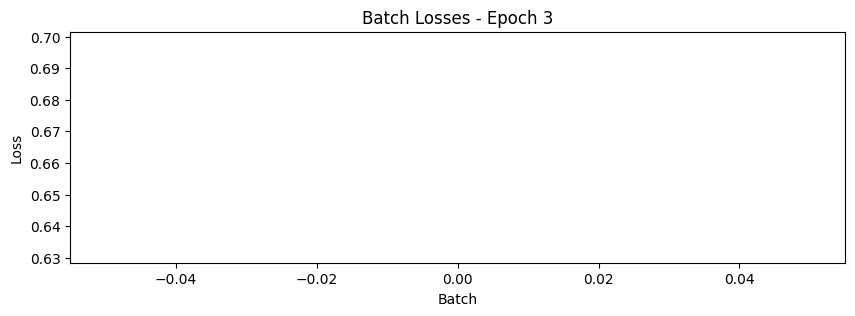

✓ Saved best model

Epoch 4/30

Gradients for atom_fc.weight:
Mean: -0.000087
Std: 0.002156

Gradients for atom_fc.bias:
Mean: -0.000745
Std: 0.005894

Gradients for neighbor_fc.weight:
Mean: -0.000098
Std: 0.000744

Gradients for neighbor_fc.bias:
Mean: -0.000621
Std: 0.001798

Gradients for GRUCell.0.weight_ih:
Mean: -0.000004
Std: 0.000539

Gradients for GRUCell.0.weight_hh:
Mean: -0.000003
Std: 0.000350

Gradients for GRUCell.0.bias_ih:
Mean: -0.000076
Std: 0.004154

Gradients for GRUCell.0.bias_hh:
Mean: -0.000057
Std: 0.002107

Gradients for GRUCell.1.weight_ih:
Mean: 0.000003
Std: 0.000630

Gradients for GRUCell.1.weight_hh:
Mean: -0.000004
Std: 0.000402

Gradients for GRUCell.1.bias_ih:
Mean: -0.000135
Std: 0.007464

Gradients for GRUCell.1.bias_hh:
Mean: -0.000108
Std: 0.003776

Gradients for GRUCell.2.weight_ih:
Mean: 0.000002
Std: 0.001064

Gradients for GRUCell.2.weight_hh:
Mean: 0.000000
Std: 0.000491

Gradients for GRUCell.2.bias_ih:
Mean: -0.000096
Std: 0.013877

Gradien

/tmp/ipykernel_778194/528031549.py:173: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  print(f"Std: {param.grad.std().item():.6f}")


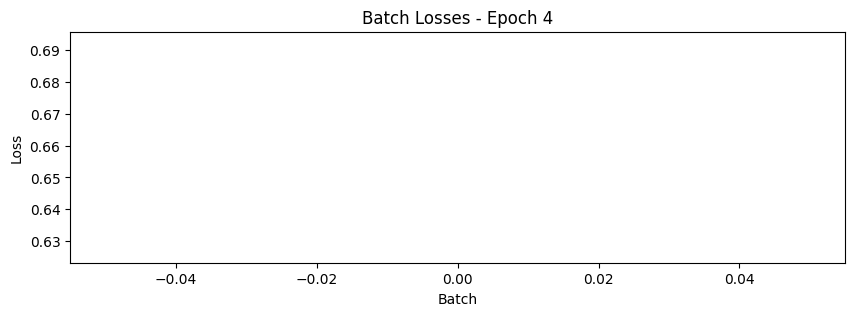

✓ Saved best model

Epoch 5/30

Gradients for atom_fc.weight:
Mean: -0.000145
Std: 0.001958

Gradients for atom_fc.bias:
Mean: -0.001283
Std: 0.004565

Gradients for neighbor_fc.weight:
Mean: -0.000085
Std: 0.000704

Gradients for neighbor_fc.bias:
Mean: -0.000546
Std: 0.001693

Gradients for GRUCell.0.weight_ih:
Mean: -0.000002
Std: 0.000494

Gradients for GRUCell.0.weight_hh:
Mean: -0.000026
Std: 0.000329

Gradients for GRUCell.0.bias_ih:
Mean: -0.000549
Std: 0.003838

Gradients for GRUCell.0.bias_hh:
Mean: -0.000299
Std: 0.001960

Gradients for GRUCell.1.weight_ih:
Mean: -0.000005
Std: 0.000581

Gradients for GRUCell.1.weight_hh:
Mean: -0.000020
Std: 0.000376

Gradients for GRUCell.1.bias_ih:
Mean: -0.000879
Std: 0.006734

Gradients for GRUCell.1.bias_hh:
Mean: -0.000477
Std: 0.003447

Gradients for GRUCell.2.weight_ih:
Mean: 0.000012
Std: 0.000979

Gradients for GRUCell.2.weight_hh:
Mean: -0.000009
Std: 0.000451

Gradients for GRUCell.2.bias_ih:
Mean: -0.001024
Std: 0.012705

Gradi

/tmp/ipykernel_778194/528031549.py:173: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  print(f"Std: {param.grad.std().item():.6f}")


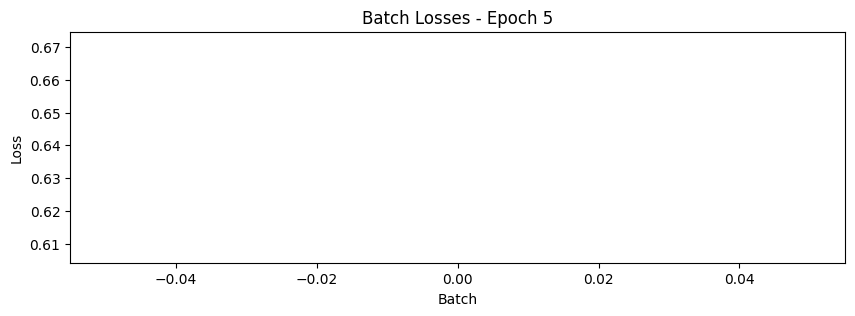

✓ Saved best model

Epoch 6/30

Gradients for atom_fc.weight:
Mean: -0.000238
Std: 0.001999

Gradients for atom_fc.bias:
Mean: -0.002077
Std: 0.005044

Gradients for neighbor_fc.weight:
Mean: -0.000089
Std: 0.000697

Gradients for neighbor_fc.bias:
Mean: -0.000562
Std: 0.001652

Gradients for GRUCell.0.weight_ih:
Mean: -0.000001
Std: 0.000549

Gradients for GRUCell.0.weight_hh:
Mean: -0.000029
Std: 0.000351

Gradients for GRUCell.0.bias_ih:
Mean: -0.000608
Std: 0.004377

Gradients for GRUCell.0.bias_hh:
Mean: -0.000322
Std: 0.002229

Gradients for GRUCell.1.weight_ih:
Mean: -0.000008
Std: 0.000631

Gradients for GRUCell.1.weight_hh:
Mean: -0.000026
Std: 0.000405

Gradients for GRUCell.1.bias_ih:
Mean: -0.001094
Std: 0.007510

Gradients for GRUCell.1.bias_hh:
Mean: -0.000594
Std: 0.003795

Gradients for GRUCell.2.weight_ih:
Mean: 0.000020
Std: 0.001039

Gradients for GRUCell.2.weight_hh:
Mean: -0.000015
Std: 0.000485

Gradients for GRUCell.2.bias_ih:
Mean: -0.001679
Std: 0.013302

Gradi

/tmp/ipykernel_778194/528031549.py:173: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  print(f"Std: {param.grad.std().item():.6f}")


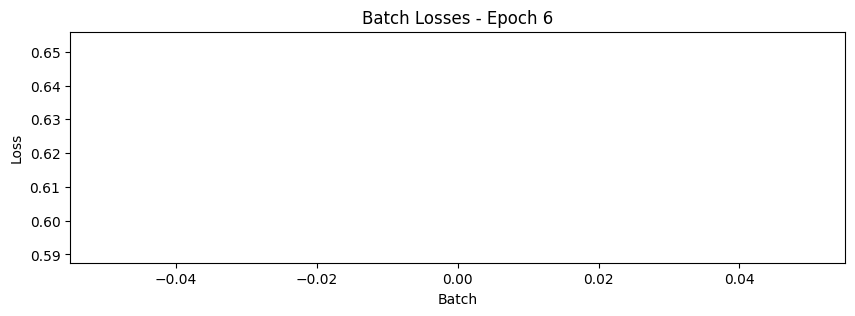

✓ Saved best model

Epoch 7/30

Gradients for atom_fc.weight:
Mean: -0.000254
Std: 0.002054

Gradients for atom_fc.bias:
Mean: -0.002247
Std: 0.004085

Gradients for neighbor_fc.weight:
Mean: -0.000084
Std: 0.000698

Gradients for neighbor_fc.bias:
Mean: -0.000516
Std: 0.001462

Gradients for GRUCell.0.weight_ih:
Mean: 0.000002
Std: 0.000493

Gradients for GRUCell.0.weight_hh:
Mean: -0.000040
Std: 0.000315

Gradients for GRUCell.0.bias_ih:
Mean: -0.000849
Std: 0.003373

Gradients for GRUCell.0.bias_hh:
Mean: -0.000443
Std: 0.001716

Gradients for GRUCell.1.weight_ih:
Mean: -0.000011
Std: 0.000529

Gradients for GRUCell.1.weight_hh:
Mean: -0.000035
Std: 0.000356

Gradients for GRUCell.1.bias_ih:
Mean: -0.001456
Std: 0.005813

Gradients for GRUCell.1.bias_hh:
Mean: -0.000784
Std: 0.002935

Gradients for GRUCell.2.weight_ih:
Mean: 0.000027
Std: 0.000847

Gradients for GRUCell.2.weight_hh:
Mean: -0.000020
Std: 0.000421

Gradients for GRUCell.2.bias_ih:
Mean: -0.002249
Std: 0.010423

Gradie

/tmp/ipykernel_778194/528031549.py:173: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  print(f"Std: {param.grad.std().item():.6f}")


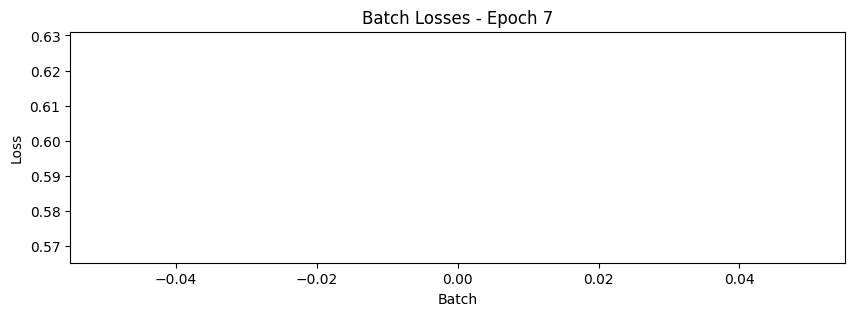

✓ Saved best model

Epoch 8/30

Gradients for atom_fc.weight:
Mean: -0.000360
Std: 0.002182

Gradients for atom_fc.bias:
Mean: -0.003171
Std: 0.004750

Gradients for neighbor_fc.weight:
Mean: -0.000102
Std: 0.000791

Gradients for neighbor_fc.bias:
Mean: -0.000630
Std: 0.001875

Gradients for GRUCell.0.weight_ih:
Mean: 0.000004
Std: 0.000556

Gradients for GRUCell.0.weight_hh:
Mean: -0.000066
Std: 0.000355

Gradients for GRUCell.0.bias_ih:
Mean: -0.001353
Std: 0.004185

Gradients for GRUCell.0.bias_hh:
Mean: -0.000724
Std: 0.002125

Gradients for GRUCell.1.weight_ih:
Mean: -0.000015
Std: 0.000602

Gradients for GRUCell.1.weight_hh:
Mean: -0.000050
Std: 0.000389

Gradients for GRUCell.1.bias_ih:
Mean: -0.002112
Std: 0.006517

Gradients for GRUCell.1.bias_hh:
Mean: -0.001111
Std: 0.003325

Gradients for GRUCell.2.weight_ih:
Mean: 0.000038
Std: 0.000917

Gradients for GRUCell.2.weight_hh:
Mean: -0.000030
Std: 0.000451

Gradients for GRUCell.2.bias_ih:
Mean: -0.003117
Std: 0.011057

Gradie

/tmp/ipykernel_778194/528031549.py:173: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  print(f"Std: {param.grad.std().item():.6f}")


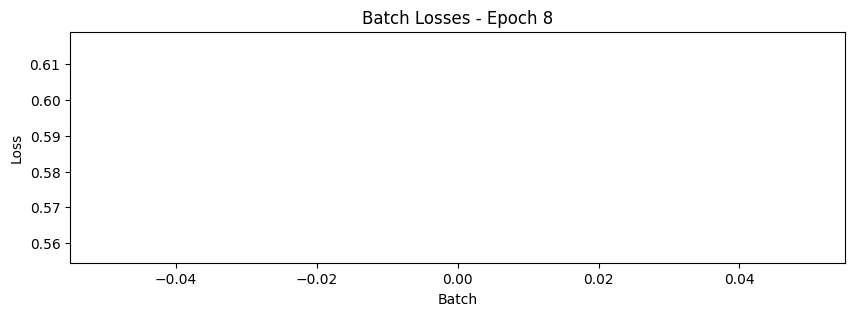

✓ Saved best model

Epoch 9/30

Gradients for atom_fc.weight:
Mean: -0.000144
Std: 0.002505

Gradients for atom_fc.bias:
Mean: -0.001256
Std: 0.006358

Gradients for neighbor_fc.weight:
Mean: -0.000093
Std: 0.000832

Gradients for neighbor_fc.bias:
Mean: -0.000580
Std: 0.002012

Gradients for GRUCell.0.weight_ih:
Mean: 0.000002
Std: 0.000576

Gradients for GRUCell.0.weight_hh:
Mean: -0.000035
Std: 0.000369

Gradients for GRUCell.0.bias_ih:
Mean: -0.000714
Std: 0.004421

Gradients for GRUCell.0.bias_hh:
Mean: -0.000387
Std: 0.002222

Gradients for GRUCell.1.weight_ih:
Mean: -0.000008
Std: 0.000690

Gradients for GRUCell.1.weight_hh:
Mean: -0.000032
Std: 0.000442

Gradients for GRUCell.1.bias_ih:
Mean: -0.001277
Std: 0.007867

Gradients for GRUCell.1.bias_hh:
Mean: -0.000711
Std: 0.004015

Gradients for GRUCell.2.weight_ih:
Mean: 0.000016
Std: 0.001109

Gradients for GRUCell.2.weight_hh:
Mean: -0.000013
Std: 0.000539

Gradients for GRUCell.2.bias_ih:
Mean: -0.001443
Std: 0.013979

Gradie

/tmp/ipykernel_778194/528031549.py:173: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  print(f"Std: {param.grad.std().item():.6f}")


Training Loss: 0.6315
Validation: Loss=0.6413, Acc=0.667, F1=0.800, AUC=0.625
Learning rate: 0.000500


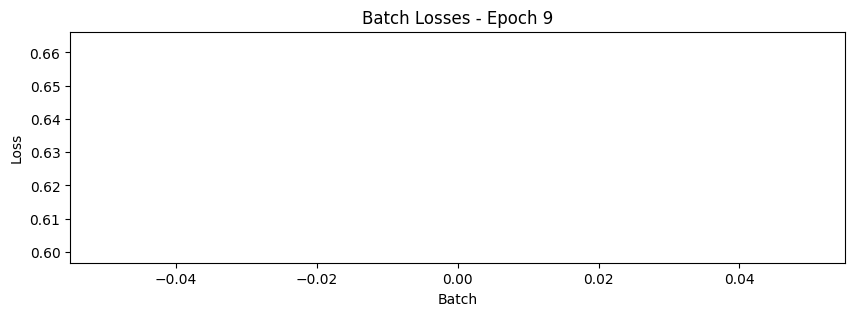

✓ Saved best model

Epoch 10/30

Gradients for atom_fc.weight:
Mean: -0.000401
Std: 0.002178

Gradients for atom_fc.bias:
Mean: -0.003539
Std: 0.004921

Gradients for neighbor_fc.weight:
Mean: -0.000136
Std: 0.000763

Gradients for neighbor_fc.bias:
Mean: -0.000843
Std: 0.001648

Gradients for GRUCell.0.weight_ih:
Mean: 0.000004
Std: 0.000543

Gradients for GRUCell.0.weight_hh:
Mean: -0.000060
Std: 0.000335

Gradients for GRUCell.0.bias_ih:
Mean: -0.001226
Std: 0.003779

Gradients for GRUCell.0.bias_hh:
Mean: -0.000659
Std: 0.001928

Gradients for GRUCell.1.weight_ih:
Mean: -0.000012
Std: 0.000595

Gradients for GRUCell.1.weight_hh:
Mean: -0.000046
Std: 0.000392

Gradients for GRUCell.1.bias_ih:
Mean: -0.001896
Std: 0.006406

Gradients for GRUCell.1.bias_hh:
Mean: -0.001010
Std: 0.003265

Gradients for GRUCell.2.weight_ih:
Mean: 0.000037
Std: 0.000965

Gradients for GRUCell.2.weight_hh:
Mean: -0.000031
Std: 0.000482

Gradients for GRUCell.2.bias_ih:
Mean: -0.003105
Std: 0.011416

Gradi

/tmp/ipykernel_778194/528031549.py:173: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  print(f"Std: {param.grad.std().item():.6f}")


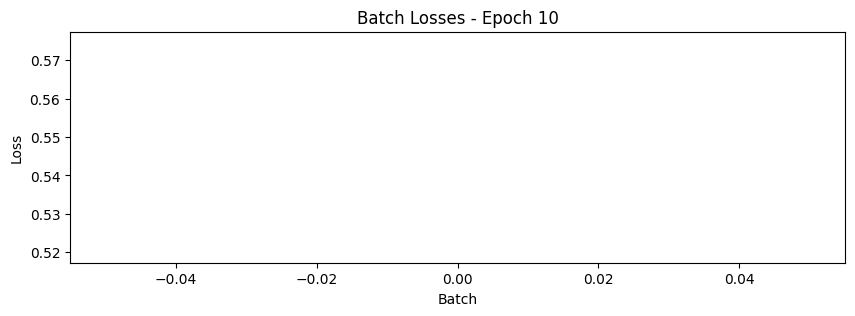

✓ Saved best model

Epoch 11/30

Gradients for atom_fc.weight:
Mean: -0.000444
Std: 0.002227

Gradients for atom_fc.bias:
Mean: -0.003894
Std: 0.004746

Gradients for neighbor_fc.weight:
Mean: -0.000127
Std: 0.000787

Gradients for neighbor_fc.bias:
Mean: -0.000770
Std: 0.001624

Gradients for GRUCell.0.weight_ih:
Mean: 0.000006
Std: 0.000554

Gradients for GRUCell.0.weight_hh:
Mean: -0.000063
Std: 0.000343

Gradients for GRUCell.0.bias_ih:
Mean: -0.001301
Std: 0.003837

Gradients for GRUCell.0.bias_hh:
Mean: -0.000687
Std: 0.001959

Gradients for GRUCell.1.weight_ih:
Mean: -0.000014
Std: 0.000593

Gradients for GRUCell.1.weight_hh:
Mean: -0.000053
Std: 0.000392

Gradients for GRUCell.1.bias_ih:
Mean: -0.002124
Std: 0.006188

Gradients for GRUCell.1.bias_hh:
Mean: -0.001137
Std: 0.003137

Gradients for GRUCell.2.weight_ih:
Mean: 0.000043
Std: 0.000934

Gradients for GRUCell.2.weight_hh:
Mean: -0.000038
Std: 0.000477

Gradients for GRUCell.2.bias_ih:
Mean: -0.003514
Std: 0.010668

Gradi

/tmp/ipykernel_778194/528031549.py:173: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  print(f"Std: {param.grad.std().item():.6f}")


Training Loss: 0.5331
Validation: Loss=0.6313, Acc=0.667, F1=0.800, AUC=0.500
Learning rate: 0.000500


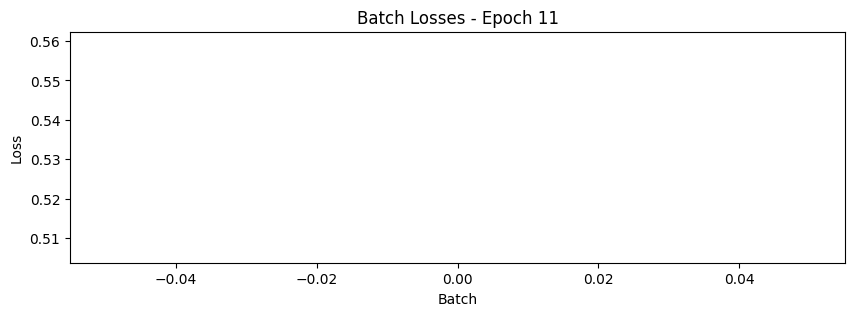

✓ Saved best model

Epoch 12/30

Gradients for atom_fc.weight:
Mean: -0.000517
Std: 0.002260

Gradients for atom_fc.bias:
Mean: -0.004553
Std: 0.005189

Gradients for neighbor_fc.weight:
Mean: -0.000152
Std: 0.000849

Gradients for neighbor_fc.bias:
Mean: -0.000939
Std: 0.001843

Gradients for GRUCell.0.weight_ih:
Mean: 0.000010
Std: 0.000616

Gradients for GRUCell.0.weight_hh:
Mean: -0.000082
Std: 0.000372

Gradients for GRUCell.0.bias_ih:
Mean: -0.001688
Std: 0.004360

Gradients for GRUCell.0.bias_hh:
Mean: -0.000895
Std: 0.002244

Gradients for GRUCell.1.weight_ih:
Mean: -0.000015
Std: 0.000672

Gradients for GRUCell.1.weight_hh:
Mean: -0.000065
Std: 0.000433

Gradients for GRUCell.1.bias_ih:
Mean: -0.002576
Std: 0.007029

Gradients for GRUCell.1.bias_hh:
Mean: -0.001356
Std: 0.003580

Gradients for GRUCell.2.weight_ih:
Mean: 0.000048
Std: 0.001069

Gradients for GRUCell.2.weight_hh:
Mean: -0.000045
Std: 0.000535

Gradients for GRUCell.2.bias_ih:
Mean: -0.004011
Std: 0.012136

Gradi

/tmp/ipykernel_778194/528031549.py:173: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  print(f"Std: {param.grad.std().item():.6f}")


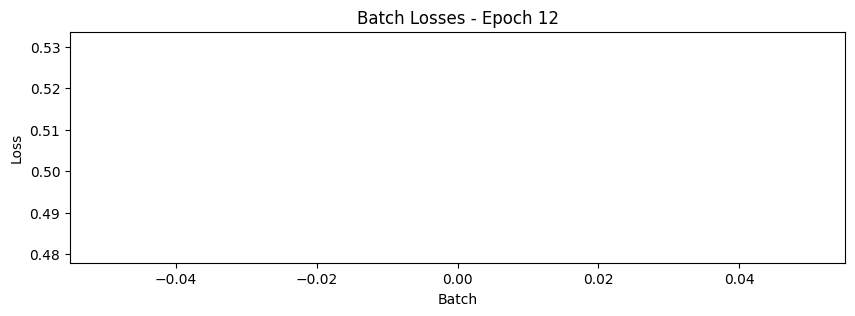

✓ Saved best model

Epoch 13/30

Gradients for atom_fc.weight:
Mean: -0.000543
Std: 0.002492

Gradients for atom_fc.bias:
Mean: -0.004743
Std: 0.005138

Gradients for neighbor_fc.weight:
Mean: -0.000170
Std: 0.000899

Gradients for neighbor_fc.bias:
Mean: -0.001061
Std: 0.001826

Gradients for GRUCell.0.weight_ih:
Mean: 0.000011
Std: 0.000633

Gradients for GRUCell.0.weight_hh:
Mean: -0.000087
Std: 0.000389

Gradients for GRUCell.0.bias_ih:
Mean: -0.001779
Std: 0.004302

Gradients for GRUCell.0.bias_hh:
Mean: -0.000943
Std: 0.002211

Gradients for GRUCell.1.weight_ih:
Mean: -0.000016
Std: 0.000697

Gradients for GRUCell.1.weight_hh:
Mean: -0.000072
Std: 0.000458

Gradients for GRUCell.1.bias_ih:
Mean: -0.002777
Std: 0.007152

Gradients for GRUCell.1.bias_hh:
Mean: -0.001473
Std: 0.003656

Gradients for GRUCell.2.weight_ih:
Mean: 0.000050
Std: 0.001084

Gradients for GRUCell.2.weight_hh:
Mean: -0.000047
Std: 0.000552

Gradients for GRUCell.2.bias_ih:
Mean: -0.004024
Std: 0.012119

Gradi

/tmp/ipykernel_778194/528031549.py:173: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  print(f"Std: {param.grad.std().item():.6f}")


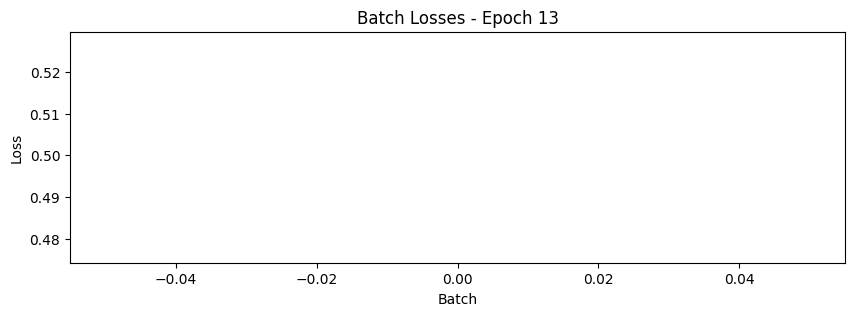

✓ Saved best model

Epoch 14/30

Gradients for atom_fc.weight:
Mean: -0.000560
Std: 0.002504

Gradients for atom_fc.bias:
Mean: -0.004889
Std: 0.005179

Gradients for neighbor_fc.weight:
Mean: -0.000175
Std: 0.000959

Gradients for neighbor_fc.bias:
Mean: -0.001095
Std: 0.001985

Gradients for GRUCell.0.weight_ih:
Mean: 0.000010
Std: 0.000621

Gradients for GRUCell.0.weight_hh:
Mean: -0.000085
Std: 0.000371

Gradients for GRUCell.0.bias_ih:
Mean: -0.001725
Std: 0.004027

Gradients for GRUCell.0.bias_hh:
Mean: -0.000915
Std: 0.002045

Gradients for GRUCell.1.weight_ih:
Mean: -0.000014
Std: 0.000649

Gradients for GRUCell.1.weight_hh:
Mean: -0.000072
Std: 0.000425

Gradients for GRUCell.1.bias_ih:
Mean: -0.002689
Std: 0.006222

Gradients for GRUCell.1.bias_hh:
Mean: -0.001434
Std: 0.003146

Gradients for GRUCell.2.weight_ih:
Mean: 0.000051
Std: 0.000952

Gradients for GRUCell.2.weight_hh:
Mean: -0.000053
Std: 0.000516

Gradients for GRUCell.2.bias_ih:
Mean: -0.004162
Std: 0.010167

Gradi

/tmp/ipykernel_778194/528031549.py:173: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  print(f"Std: {param.grad.std().item():.6f}")


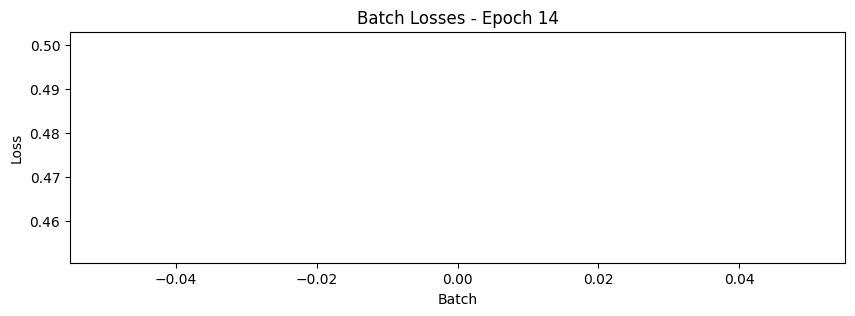

✓ Saved best model

Epoch 15/30

Gradients for atom_fc.weight:
Mean: -0.000633
Std: 0.002705

Gradients for atom_fc.bias:
Mean: -0.005526
Std: 0.007089

Gradients for neighbor_fc.weight:
Mean: -0.000218
Std: 0.001121

Gradients for neighbor_fc.bias:
Mean: -0.001369
Std: 0.002714

Gradients for GRUCell.0.weight_ih:
Mean: 0.000015
Std: 0.000757

Gradients for GRUCell.0.weight_hh:
Mean: -0.000104
Std: 0.000435

Gradients for GRUCell.0.bias_ih:
Mean: -0.002090
Std: 0.005441

Gradients for GRUCell.0.bias_hh:
Mean: -0.001103
Std: 0.002726

Gradients for GRUCell.1.weight_ih:
Mean: -0.000019
Std: 0.000789

Gradients for GRUCell.1.weight_hh:
Mean: -0.000089
Std: 0.000498

Gradients for GRUCell.1.bias_ih:
Mean: -0.003239
Std: 0.007868

Gradients for GRUCell.1.bias_hh:
Mean: -0.001718
Std: 0.003995

Gradients for GRUCell.2.weight_ih:
Mean: 0.000062
Std: 0.001164

Gradients for GRUCell.2.weight_hh:
Mean: -0.000068
Std: 0.000619

Gradients for GRUCell.2.bias_ih:
Mean: -0.004943
Std: 0.012518

Gradi

/tmp/ipykernel_778194/528031549.py:173: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  print(f"Std: {param.grad.std().item():.6f}")


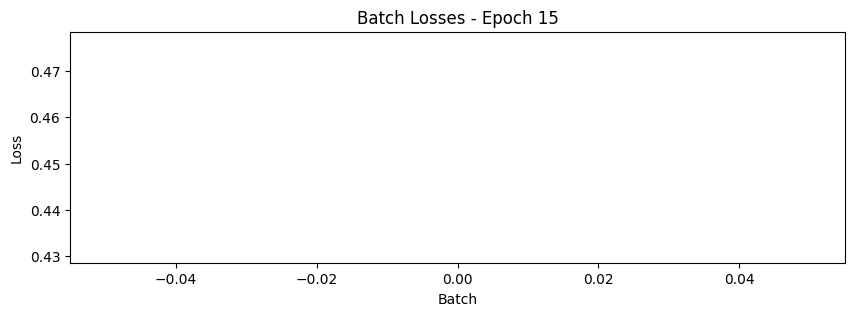

✓ Saved best model

Epoch 16/30

Gradients for atom_fc.weight:
Mean: -0.000608
Std: 0.003182

Gradients for atom_fc.bias:
Mean: -0.005268
Std: 0.008227

Gradients for neighbor_fc.weight:
Mean: -0.000250
Std: 0.001254

Gradients for neighbor_fc.bias:
Mean: -0.001602
Std: 0.002817

Gradients for GRUCell.0.weight_ih:
Mean: 0.000012
Std: 0.000831

Gradients for GRUCell.0.weight_hh:
Mean: -0.000098
Std: 0.000491

Gradients for GRUCell.0.bias_ih:
Mean: -0.001940
Std: 0.005849

Gradients for GRUCell.0.bias_hh:
Mean: -0.001033
Std: 0.002948

Gradients for GRUCell.1.weight_ih:
Mean: -0.000014
Std: 0.000907

Gradients for GRUCell.1.weight_hh:
Mean: -0.000087
Std: 0.000584

Gradients for GRUCell.1.bias_ih:
Mean: -0.003027
Std: 0.009111

Gradients for GRUCell.1.bias_hh:
Mean: -0.001626
Std: 0.004684

Gradients for GRUCell.2.weight_ih:
Mean: 0.000056
Std: 0.001454

Gradients for GRUCell.2.weight_hh:
Mean: -0.000066
Std: 0.000764

Gradients for GRUCell.2.bias_ih:
Mean: -0.004504
Std: 0.015924

Gradi

/tmp/ipykernel_778194/528031549.py:173: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  print(f"Std: {param.grad.std().item():.6f}")


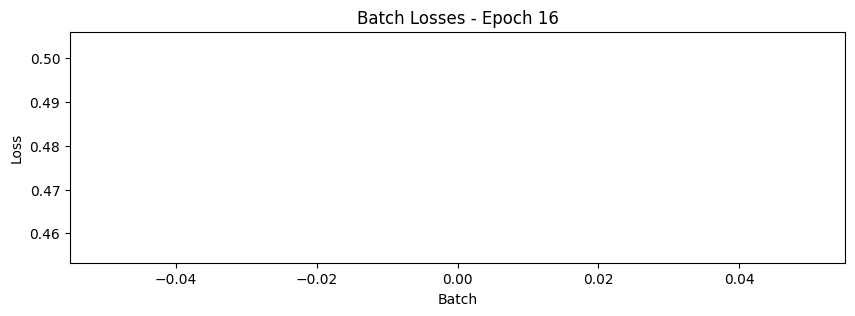

✓ Saved best model

Epoch 17/30

Gradients for atom_fc.weight:
Mean: -0.000650
Std: 0.002801

Gradients for atom_fc.bias:
Mean: -0.005651
Std: 0.006148

Gradients for neighbor_fc.weight:
Mean: -0.000205
Std: 0.001096

Gradients for neighbor_fc.bias:
Mean: -0.001282
Std: 0.002122

Gradients for GRUCell.0.weight_ih:
Mean: 0.000013
Std: 0.000753

Gradients for GRUCell.0.weight_hh:
Mean: -0.000088
Std: 0.000432

Gradients for GRUCell.0.bias_ih:
Mean: -0.001767
Std: 0.004723

Gradients for GRUCell.0.bias_hh:
Mean: -0.000928
Std: 0.002417

Gradients for GRUCell.1.weight_ih:
Mean: -0.000014
Std: 0.000811

Gradients for GRUCell.1.weight_hh:
Mean: -0.000083
Std: 0.000536

Gradients for GRUCell.1.bias_ih:
Mean: -0.002838
Std: 0.007622

Gradients for GRUCell.1.bias_hh:
Mean: -0.001522
Std: 0.003964

Gradients for GRUCell.2.weight_ih:
Mean: 0.000057
Std: 0.001225

Gradients for GRUCell.2.weight_hh:
Mean: -0.000076
Std: 0.000686

Gradients for GRUCell.2.bias_ih:
Mean: -0.004729
Std: 0.012608

Gradi

/tmp/ipykernel_778194/528031549.py:173: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  print(f"Std: {param.grad.std().item():.6f}")


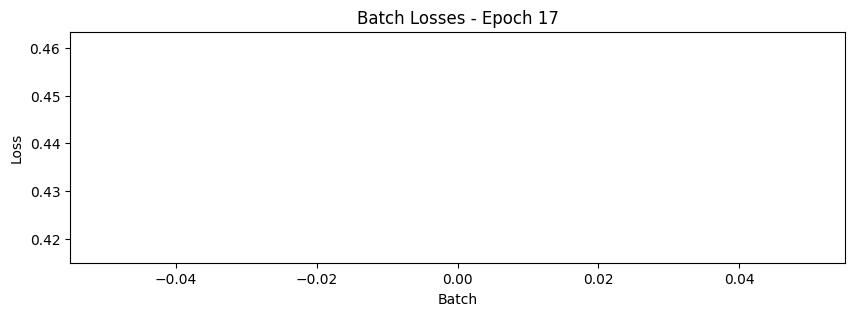

✓ Saved best model

Epoch 18/30

Gradients for atom_fc.weight:
Mean: -0.000676
Std: 0.002987

Gradients for atom_fc.bias:
Mean: -0.005833
Std: 0.006600

Gradients for neighbor_fc.weight:
Mean: -0.000232
Std: 0.001179

Gradients for neighbor_fc.bias:
Mean: -0.001436
Std: 0.002229

Gradients for GRUCell.0.weight_ih:
Mean: 0.000012
Std: 0.000771

Gradients for GRUCell.0.weight_hh:
Mean: -0.000089
Std: 0.000435

Gradients for GRUCell.0.bias_ih:
Mean: -0.001767
Std: 0.004555

Gradients for GRUCell.0.bias_hh:
Mean: -0.000921
Std: 0.002311

Gradients for GRUCell.1.weight_ih:
Mean: -0.000010
Std: 0.000813

Gradients for GRUCell.1.weight_hh:
Mean: -0.000083
Std: 0.000537

Gradients for GRUCell.1.bias_ih:
Mean: -0.002696
Std: 0.007373

Gradients for GRUCell.1.bias_hh:
Mean: -0.001474
Std: 0.003758

Gradients for GRUCell.2.weight_ih:
Mean: 0.000051
Std: 0.001235

Gradients for GRUCell.2.weight_hh:
Mean: -0.000071
Std: 0.000690

Gradients for GRUCell.2.bias_ih:
Mean: -0.004170
Std: 0.012328

Gradi

/tmp/ipykernel_778194/528031549.py:173: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  print(f"Std: {param.grad.std().item():.6f}")


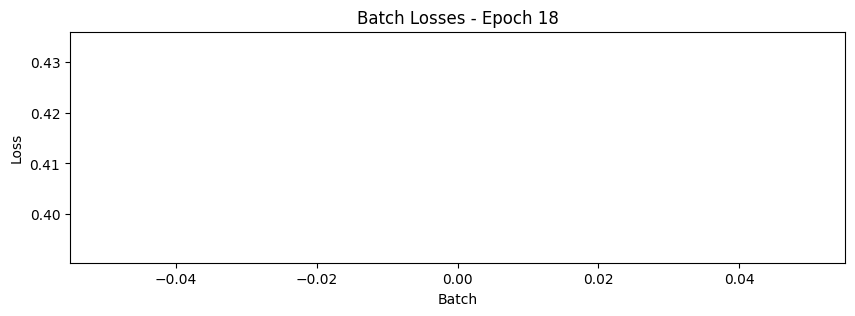

✓ Saved best model

Epoch 19/30

Gradients for atom_fc.weight:
Mean: -0.000685
Std: 0.002882

Gradients for atom_fc.bias:
Mean: -0.005933
Std: 0.007257

Gradients for neighbor_fc.weight:
Mean: -0.000264
Std: 0.001122

Gradients for neighbor_fc.bias:
Mean: -0.001664
Std: 0.002099

Gradients for GRUCell.0.weight_ih:
Mean: 0.000010
Std: 0.000771

Gradients for GRUCell.0.weight_hh:
Mean: -0.000082
Std: 0.000432

Gradients for GRUCell.0.bias_ih:
Mean: -0.001604
Std: 0.004659

Gradients for GRUCell.0.bias_hh:
Mean: -0.000843
Std: 0.002427

Gradients for GRUCell.1.weight_ih:
Mean: -0.000009
Std: 0.000781

Gradients for GRUCell.1.weight_hh:
Mean: -0.000075
Std: 0.000526

Gradients for GRUCell.1.bias_ih:
Mean: -0.002353
Std: 0.006994

Gradients for GRUCell.1.bias_hh:
Mean: -0.001287
Std: 0.003596

Gradients for GRUCell.2.weight_ih:
Mean: 0.000046
Std: 0.001249

Gradients for GRUCell.2.weight_hh:
Mean: -0.000070
Std: 0.000702

Gradients for GRUCell.2.bias_ih:
Mean: -0.003882
Std: 0.012037

Gradi

/tmp/ipykernel_778194/528031549.py:173: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  print(f"Std: {param.grad.std().item():.6f}")


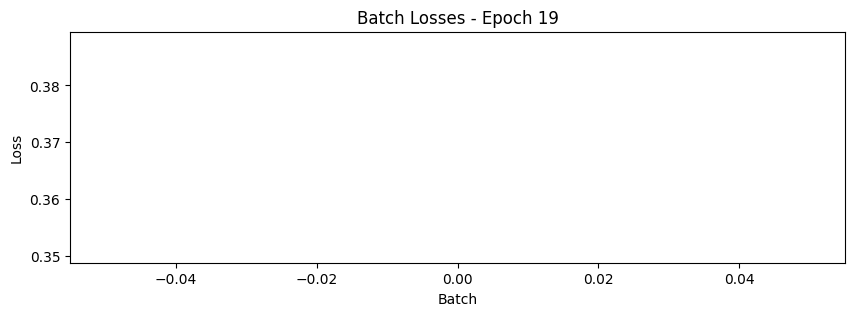

✓ Saved best model

Epoch 20/30

Gradients for atom_fc.weight:
Mean: -0.000647
Std: 0.002661

Gradients for atom_fc.bias:
Mean: -0.005627
Std: 0.006677

Gradients for neighbor_fc.weight:
Mean: -0.000260
Std: 0.001074

Gradients for neighbor_fc.bias:
Mean: -0.001628
Std: 0.002102

Gradients for GRUCell.0.weight_ih:
Mean: 0.000013
Std: 0.000744

Gradients for GRUCell.0.weight_hh:
Mean: -0.000082
Std: 0.000404

Gradients for GRUCell.0.bias_ih:
Mean: -0.001592
Std: 0.004420

Gradients for GRUCell.0.bias_hh:
Mean: -0.000833
Std: 0.002318

Gradients for GRUCell.1.weight_ih:
Mean: -0.000011
Std: 0.000718

Gradients for GRUCell.1.weight_hh:
Mean: -0.000074
Std: 0.000478

Gradients for GRUCell.1.bias_ih:
Mean: -0.002231
Std: 0.006200

Gradients for GRUCell.1.bias_hh:
Mean: -0.001221
Std: 0.003165

Gradients for GRUCell.2.weight_ih:
Mean: 0.000040
Std: 0.001150

Gradients for GRUCell.2.weight_hh:
Mean: -0.000069
Std: 0.000650

Gradients for GRUCell.2.bias_ih:
Mean: -0.003569
Std: 0.010696

Gradi

/tmp/ipykernel_778194/528031549.py:173: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  print(f"Std: {param.grad.std().item():.6f}")


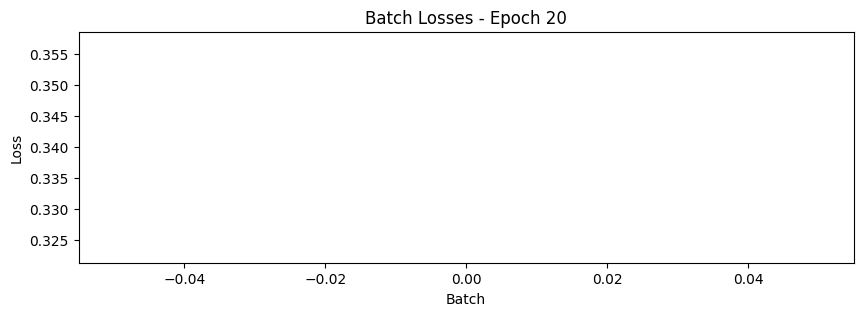

✓ Saved best model

Epoch 21/30

Gradients for atom_fc.weight:
Mean: -0.000737
Std: 0.002986

Gradients for atom_fc.bias:
Mean: -0.006375
Std: 0.007323

Gradients for neighbor_fc.weight:
Mean: -0.000288
Std: 0.001230

Gradients for neighbor_fc.bias:
Mean: -0.001790
Std: 0.002187

Gradients for GRUCell.0.weight_ih:
Mean: 0.000014
Std: 0.000808

Gradients for GRUCell.0.weight_hh:
Mean: -0.000095
Std: 0.000439

Gradients for GRUCell.0.bias_ih:
Mean: -0.001849
Std: 0.004692

Gradients for GRUCell.0.bias_hh:
Mean: -0.000962
Std: 0.002437

Gradients for GRUCell.1.weight_ih:
Mean: -0.000014
Std: 0.000825

Gradients for GRUCell.1.weight_hh:
Mean: -0.000091
Std: 0.000552

Gradients for GRUCell.1.bias_ih:
Mean: -0.002689
Std: 0.007082

Gradients for GRUCell.1.bias_hh:
Mean: -0.001459
Std: 0.003709

Gradients for GRUCell.2.weight_ih:
Mean: 0.000053
Std: 0.001221

Gradients for GRUCell.2.weight_hh:
Mean: -0.000087
Std: 0.000720

Gradients for GRUCell.2.bias_ih:
Mean: -0.004192
Std: 0.011148

Gradi

/tmp/ipykernel_778194/528031549.py:173: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  print(f"Std: {param.grad.std().item():.6f}")


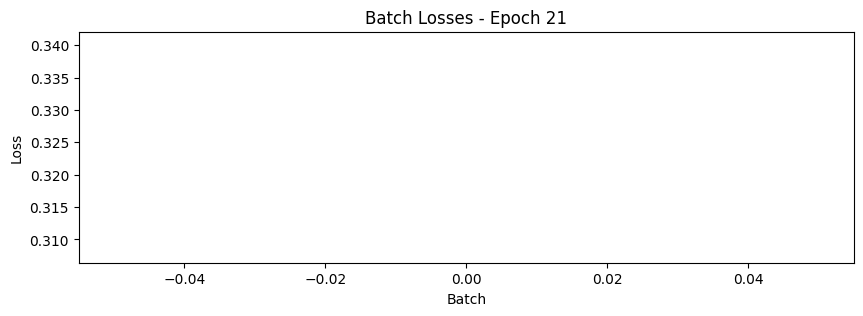

✓ Saved best model

Epoch 22/30

Gradients for atom_fc.weight:
Mean: -0.000682
Std: 0.002861

Gradients for atom_fc.bias:
Mean: -0.005928
Std: 0.008754

Gradients for neighbor_fc.weight:
Mean: -0.000300
Std: 0.001211

Gradients for neighbor_fc.bias:
Mean: -0.001886
Std: 0.002801

Gradients for GRUCell.0.weight_ih:
Mean: 0.000010
Std: 0.000824

Gradients for GRUCell.0.weight_hh:
Mean: -0.000077
Std: 0.000441

Gradients for GRUCell.0.bias_ih:
Mean: -0.001450
Std: 0.005042

Gradients for GRUCell.0.bias_hh:
Mean: -0.000762
Std: 0.002666

Gradients for GRUCell.1.weight_ih:
Mean: -0.000007
Std: 0.000828

Gradients for GRUCell.1.weight_hh:
Mean: -0.000069
Std: 0.000549

Gradients for GRUCell.1.bias_ih:
Mean: -0.001930
Std: 0.007158

Gradients for GRUCell.1.bias_hh:
Mean: -0.001056
Std: 0.003707

Gradients for GRUCell.2.weight_ih:
Mean: 0.000033
Std: 0.001317

Gradients for GRUCell.2.weight_hh:
Mean: -0.000067
Std: 0.000750

Gradients for GRUCell.2.bias_ih:
Mean: -0.003099
Std: 0.011963

Gradi

/tmp/ipykernel_778194/528031549.py:173: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  print(f"Std: {param.grad.std().item():.6f}")


Training Loss: 0.2656
Validation: Loss=0.5432, Acc=0.833, F1=0.889, AUC=0.625
Learning rate: 0.000500


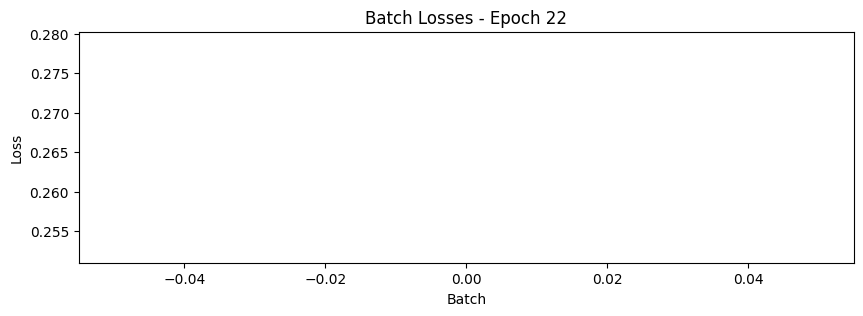

✓ Saved best model

Epoch 23/30

Gradients for atom_fc.weight:
Mean: -0.000760
Std: 0.003045

Gradients for atom_fc.bias:
Mean: -0.006599
Std: 0.007107

Gradients for neighbor_fc.weight:
Mean: -0.000335
Std: 0.001338

Gradients for neighbor_fc.bias:
Mean: -0.002096
Std: 0.002352

Gradients for GRUCell.0.weight_ih:
Mean: 0.000014
Std: 0.000817

Gradients for GRUCell.0.weight_hh:
Mean: -0.000090
Std: 0.000421

Gradients for GRUCell.0.bias_ih:
Mean: -0.001716
Std: 0.004175

Gradients for GRUCell.0.bias_hh:
Mean: -0.000890
Std: 0.002202

Gradients for GRUCell.1.weight_ih:
Mean: -0.000010
Std: 0.000781

Gradients for GRUCell.1.weight_hh:
Mean: -0.000090
Std: 0.000526

Gradients for GRUCell.1.bias_ih:
Mean: -0.002433
Std: 0.005963

Gradients for GRUCell.1.bias_hh:
Mean: -0.001341
Std: 0.003087

Gradients for GRUCell.2.weight_ih:
Mean: 0.000042
Std: 0.001186

Gradients for GRUCell.2.weight_hh:
Mean: -0.000086
Std: 0.000712

Gradients for GRUCell.2.bias_ih:
Mean: -0.003663
Std: 0.009945

Gradi

/tmp/ipykernel_778194/528031549.py:173: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  print(f"Std: {param.grad.std().item():.6f}")


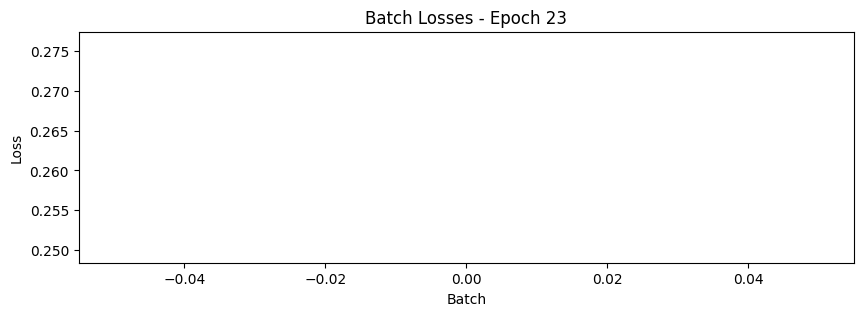


Epoch 24/30

Gradients for atom_fc.weight:
Mean: -0.000680
Std: 0.002881

Gradients for atom_fc.bias:
Mean: -0.005936
Std: 0.008932

Gradients for neighbor_fc.weight:
Mean: -0.000320
Std: 0.001336

Gradients for neighbor_fc.bias:
Mean: -0.001999
Std: 0.003155

Gradients for GRUCell.0.weight_ih:
Mean: 0.000010
Std: 0.000844

Gradients for GRUCell.0.weight_hh:
Mean: -0.000073
Std: 0.000440

Gradients for GRUCell.0.bias_ih:
Mean: -0.001347
Std: 0.004897

Gradients for GRUCell.0.bias_hh:
Mean: -0.000704
Std: 0.002610

Gradients for GRUCell.1.weight_ih:
Mean: -0.000005
Std: 0.000831

Gradients for GRUCell.1.weight_hh:
Mean: -0.000068
Std: 0.000549

Gradients for GRUCell.1.bias_ih:
Mean: -0.001755
Std: 0.006613

Gradients for GRUCell.1.bias_hh:
Mean: -0.000971
Std: 0.003457

Gradients for GRUCell.2.weight_ih:
Mean: 0.000027
Std: 0.001310

Gradients for GRUCell.2.weight_hh:
Mean: -0.000065
Std: 0.000766

Gradients for GRUCell.2.bias_ih:
Mean: -0.002669
Std: 0.011053

Gradients for GRUCell.2.

/tmp/ipykernel_778194/528031549.py:173: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  print(f"Std: {param.grad.std().item():.6f}")


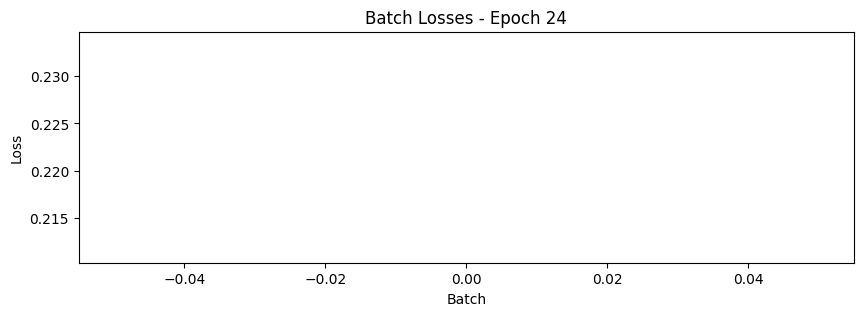


Epoch 25/30

Gradients for atom_fc.weight:
Mean: -0.000667
Std: 0.002572

Gradients for atom_fc.bias:
Mean: -0.005825
Std: 0.007174

Gradients for neighbor_fc.weight:
Mean: -0.000329
Std: 0.001222

Gradients for neighbor_fc.bias:
Mean: -0.002061
Std: 0.002541

Gradients for GRUCell.0.weight_ih:
Mean: 0.000011
Std: 0.000754

Gradients for GRUCell.0.weight_hh:
Mean: -0.000074
Std: 0.000385

Gradients for GRUCell.0.bias_ih:
Mean: -0.001373
Std: 0.004100

Gradients for GRUCell.0.bias_hh:
Mean: -0.000712
Std: 0.002195

Gradients for GRUCell.1.weight_ih:
Mean: -0.000006
Std: 0.000717

Gradients for GRUCell.1.weight_hh:
Mean: -0.000073
Std: 0.000480

Gradients for GRUCell.1.bias_ih:
Mean: -0.001824
Std: 0.005367

Gradients for GRUCell.1.bias_hh:
Mean: -0.001007
Std: 0.002805

Gradients for GRUCell.2.weight_ih:
Mean: 0.000026
Std: 0.001111

Gradients for GRUCell.2.weight_hh:
Mean: -0.000071
Std: 0.000665

Gradients for GRUCell.2.bias_ih:
Mean: -0.002726
Std: 0.008843

Gradients for GRUCell.2.

/tmp/ipykernel_778194/528031549.py:173: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  print(f"Std: {param.grad.std().item():.6f}")


Training Loss: 0.1954
Validation: Loss=0.5902, Acc=0.667, F1=0.800, AUC=0.500
Learning rate: 0.000500


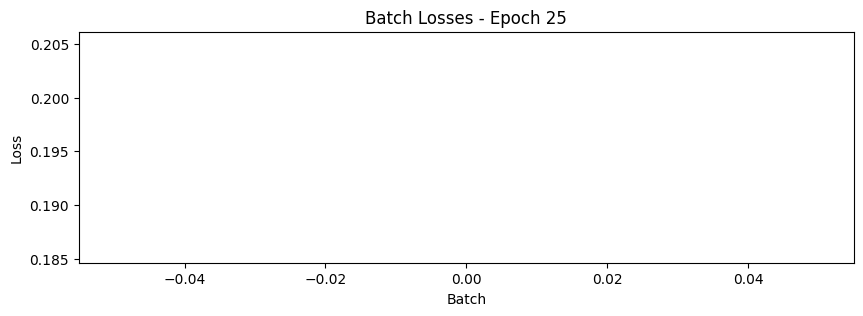


Epoch 26/30

Gradients for atom_fc.weight:
Mean: -0.000697
Std: 0.002632

Gradients for atom_fc.bias:
Mean: -0.006070
Std: 0.006150

Gradients for neighbor_fc.weight:
Mean: -0.000294
Std: 0.001231

Gradients for neighbor_fc.bias:
Mean: -0.001833
Std: 0.002139

Gradients for GRUCell.0.weight_ih:
Mean: 0.000014
Std: 0.000705

Gradients for GRUCell.0.weight_hh:
Mean: -0.000092
Std: 0.000359

Gradients for GRUCell.0.bias_ih:
Mean: -0.001675
Std: 0.003549

Gradients for GRUCell.0.bias_hh:
Mean: -0.000876
Std: 0.001890

Gradients for GRUCell.1.weight_ih:
Mean: -0.000011
Std: 0.000686

Gradients for GRUCell.1.weight_hh:
Mean: -0.000095
Std: 0.000448

Gradients for GRUCell.1.bias_ih:
Mean: -0.002378
Std: 0.004821

Gradients for GRUCell.1.bias_hh:
Mean: -0.001282
Std: 0.002482

Gradients for GRUCell.2.weight_ih:
Mean: 0.000036
Std: 0.000969

Gradients for GRUCell.2.weight_hh:
Mean: -0.000089
Std: 0.000606

Gradients for GRUCell.2.bias_ih:
Mean: -0.003246
Std: 0.007305

Gradients for GRUCell.2.

/tmp/ipykernel_778194/528031549.py:173: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  print(f"Std: {param.grad.std().item():.6f}")


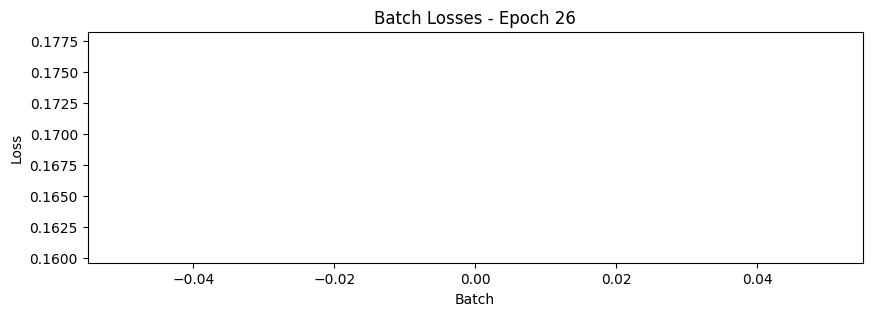


Epoch 27/30

Gradients for atom_fc.weight:
Mean: -0.000656
Std: 0.002381

Gradients for atom_fc.bias:
Mean: -0.005717
Std: 0.005600

Gradients for neighbor_fc.weight:
Mean: -0.000302
Std: 0.001156

Gradients for neighbor_fc.bias:
Mean: -0.001897
Std: 0.001906

Gradients for GRUCell.0.weight_ih:
Mean: 0.000012
Std: 0.000654

Gradients for GRUCell.0.weight_hh:
Mean: -0.000080
Std: 0.000320

Gradients for GRUCell.0.bias_ih:
Mean: -0.001460
Std: 0.003041

Gradients for GRUCell.0.bias_hh:
Mean: -0.000756
Std: 0.001627

Gradients for GRUCell.1.weight_ih:
Mean: -0.000007
Std: 0.000607

Gradients for GRUCell.1.weight_hh:
Mean: -0.000083
Std: 0.000408

Gradients for GRUCell.1.bias_ih:
Mean: -0.001971
Std: 0.003964

Gradients for GRUCell.1.bias_hh:
Mean: -0.001075
Std: 0.002070

Gradients for GRUCell.2.weight_ih:
Mean: 0.000026
Std: 0.000881

Gradients for GRUCell.2.weight_hh:
Mean: -0.000079
Std: 0.000551

Gradients for GRUCell.2.bias_ih:
Mean: -0.002700
Std: 0.006103

Gradients for GRUCell.2.

/tmp/ipykernel_778194/528031549.py:173: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  print(f"Std: {param.grad.std().item():.6f}")


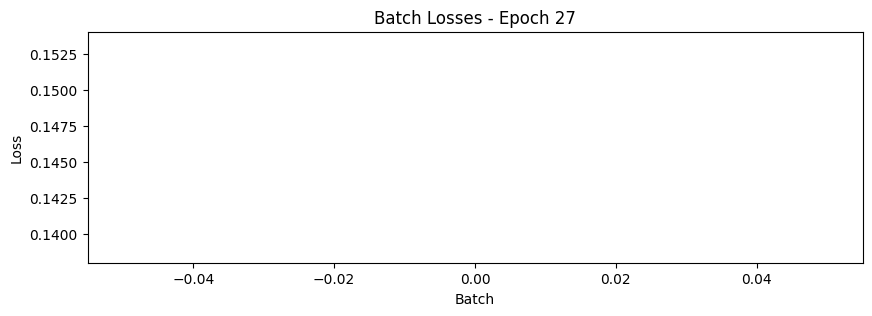

Early stopping triggered!


In [71]:
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.metrics import precision_recall_curve, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_training_metrics(model, test_loader):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch in test_loader:
            atom, bond, atom_deg, bond_deg, mask, target = [
                t.to(device) for t in batch
            ]
            _, pred, _ = model(atom, bond, atom_deg, bond_deg, mask)
            prob = torch.sigmoid(pred).cpu().numpy()
            all_preds.extend(prob)
            all_targets.extend(target.cpu().numpy())

    # Precision-Recall curve
    precision, recall, _ = precision_recall_curve(all_targets, all_preds)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')

    # Confusion Matrix
    cm = confusion_matrix(all_targets, (np.array(all_preds) > 0.5).astype(int))
    plt.subplot(1, 2, 2)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.show()

# Call after training
plot_training_metrics(model, test_loader)
def detailed_evaluate(loader):
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []
    all_probs = []
    batch_count = 0

    with torch.no_grad():
        for atom, bond, atom_deg, bond_deg, mask, target in loader:
            batch_count += 1
            atom, bond, atom_deg, bond_deg, mask, target = [
                t.to(device) for t in (atom, bond, atom_deg, bond_deg, mask, target)
            ]
            _, pred, _ = model(atom, bond, atom_deg, bond_deg, mask)
            pred = pred.view(-1)
            target = target.view(-1).float()

            loss = loss_fn(pred, target)
            total_loss += loss.item()

            prob = torch.sigmoid(pred).cpu().numpy()
            preds = (prob > 0.5).astype(int)
            
            # Diagnostic prints
            print(f"\nBatch {batch_count} Statistics:")
            print(f"Predictions distribution: {np.unique(preds, return_counts=True)}")
            print(f"Targets distribution: {np.unique(target.cpu().numpy(), return_counts=True)}")
            print(f"Raw probabilities range: {prob.min():.3f} to {prob.max():.3f}")
            
            all_probs.extend(prob)
            all_preds.extend(preds)
            all_targets.extend(target.cpu().numpy())

    # Overall statistics
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    
    print("\nOverall Statistics:")
    print(f"Total predictions shape: {all_preds.shape}")
    print(f"Predictions distribution: {np.unique(all_preds, return_counts=True)}")
    print(f"Targets distribution: {np.unique(all_targets, return_counts=True)}")
    
    # Compute metrics
    acc = accuracy_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds, zero_division=0)
    try:
        auc = roc_auc_score(all_targets, all_probs)
    except:
        auc = 0.0
        
    # Detailed metrics
    from sklearn.metrics import precision_score, recall_score, confusion_matrix
    precision = precision_score(all_targets, all_preds, zero_division=0)
    recall = recall_score(all_targets, all_preds, zero_division=0)
    cm = confusion_matrix(all_targets, all_preds)
    
    print("\nDetailed Metrics:")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print("Confusion Matrix:")
    print(cm)
    
    return total_loss, acc, f1, auc

# Let's also check the class distribution in our datasets
def check_data_distribution():
    print("\nChecking data distribution:")
    
    def get_distribution(loader):
        targets = []
        for _, _, _, _, _, target in loader:
            targets.extend(target.numpy())
        return np.unique(targets, return_counts=True)
    
    print("Training set distribution:", get_distribution(train_loader))
    print("Validation set distribution:", get_distribution(val_loader))
    print("Test set distribution:", get_distribution(test_loader))

# Run the checks
print("Checking initial data distribution...")
check_data_distribution()

print("\nRunning detailed evaluation on validation set...")
val_metrics = detailed_evaluate(val_loader)
# 1. First, let's verify our data structure:
def inspect_data():
    # Get one batch
    batch = next(iter(train_loader))
    atom, bond, atom_deg, bond_deg, mask, target = batch
    
    print("Data Inspection:")
    print(f"Batch sizes:")
    print(f"Atom features: {atom.shape}")
    print(f"Bond features: {bond.shape}")
    print(f"Target distribution in batch: {torch.unique(target, return_counts=True)}")
    return batch

# 2. Let's check our model's architecture
def inspect_model(batch):
    atom, bond, atom_deg, bond_deg, mask, target = [t.to(device) for t in batch]
    
    model.eval()
    with torch.no_grad():
        _, pred, _ = model(atom, bond, atom_deg, bond_deg, mask)
        print("\nModel Output Inspection:")
        print(f"Raw predictions shape: {pred.shape}")
        print(f"Raw predictions range: {pred.min().item():.3f} to {pred.max().item():.3f}")
        probs = torch.sigmoid(pred)
        print(f"Probabilities range: {probs.min().item():.3f} to {probs.max().item():.3f}")

# 3. Let's track detailed training progress
def train_one_epoch(epoch):
    model.train()
    total_loss = 0
    batch_losses = []
    
    for i, batch in enumerate(train_loader):
        atom, bond, atom_deg, bond_deg, mask, target = [t.to(device) for t in batch]
        
        optimizer.zero_grad()
        _, pred, _ = model(atom, bond, atom_deg, bond_deg, mask)
        loss = loss_fn(pred.squeeze(), target)
        
        loss.backward()
        # Print gradients for first layer
        if i == 0:  # Only for first batch
            for name, param in model.named_parameters():
                if param.grad is not None:
                    print(f"\nGradients for {name}:")
                    print(f"Mean: {param.grad.mean().item():.6f}")
                    print(f"Std: {param.grad.std().item():.6f}")
        
        optimizer.step()
        total_loss += loss.item()
        batch_losses.append(loss.item())
    
    return total_loss / len(train_loader), batch_losses

# 4. Modified training loop with detailed monitoring
num_epochs = 30
best_val_loss = float('inf')
patience = 5
patience_counter = 0

# Initialize model with modified parameters
model = Fingerprint(
    radius=3,  # Reduced from 5
    T=2,      # Reduced from 3
    input_feature_dim=num_atom_features(),
    input_bond_dim=num_bond_features(),
    fingerprint_dim=64,  # Reduced from 150
    output_units_num=1,
    p_dropout=0.1  # Reduced from 0.3
).to(device)

# Initialize optimizer with lower learning rate
optimizer = Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.2, patience=3
)

# Calculate proper class weights
train_labels = [target for _, _, _, _, _, target in train_loader.dataset]
pos_weight = torch.tensor([(1-np.mean(train_labels))/np.mean(train_labels)], device=device)
print(f"Calculated positive class weight: {pos_weight.item():.3f}")

loss_fn = BCEWithLogitsLoss(pos_weight=pos_weight)

# Training loop
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    # Training
    train_loss, batch_losses = train_one_epoch(epoch)
    
    # Validation
    val_loss, val_acc, val_f1, val_auc = evaluate(val_loader)
    
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Validation: Loss={val_loss:.4f}, Acc={val_acc:.3f}, F1={val_f1:.3f}, AUC={val_auc:.3f}")
    print(f"Learning rate: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Plot batch losses for this epoch
    plt.figure(figsize=(10, 3))
    plt.plot(batch_losses)
    plt.title(f'Batch Losses - Epoch {epoch+1}')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.show()
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), f"../models/model_{model_name}_best.pt")
        print("✓ Saved best model")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break
    
    scheduler.step(val_loss)